# Artificial Intelligence Course - Fall 1402
## Computer Assignment #2 - Reinforcement Learning (RL)

### Mehdi Jamalkhah, SID: 810100111

### Table of Contents<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Part 1: Value Iteration & Policy Iteration Algorithms](#toc2_)    
  - [Problem Description](#toc2_1_)    
  - [Value Iteration Algorithm](#toc2_2_)    
  - [Implementation of Value Iteration Algorithm](#toc2_3_)    
  - [Policy Iteration Algorithm](#toc2_4_)    
  - [Implementation of Policy Iteration Algorithm](#toc2_5_)    
  - [Execute the algorithm and display the results.](#toc2_6_)    
    - [Value Iteration:](#toc2_6_1_)    
    - [Policy Iteration:](#toc2_6_2_)    
  - [Value Iteration VS. Policy Iteration](#toc2_7_)    
    - [Value Iteration:](#toc2_7_1_)    
    - [Policy Iteration:](#toc2_7_2_)    
- [Part 2: Q-Learning Algorithm](#toc3_)    
  - [Problem Description](#toc3_1_)    
  - [Q-Learning Algorithm](#toc3_2_)    
  - [Implementation of Q-Learning Algorithm](#toc3_3_)    
  - [Constant Learning Rate VS. Decaying Learning Rate](#toc3_4_)    
  - [Visualizing the Agent's Behavior](#toc3_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<a name='0'></a>
## <a id='toc1_'></a>Introduction [](#toc0_)
In this project, we will discuss Markov Decision Processes (MDP) and Reinforcement Learning (RL) in context of two problems in the [Gym](https://gymnasium.farama.org/) library.
In the first part, we aim to solve the [Frozen Lake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) problem using two algorithms: Value Iteration and Policy Iteration algorithms.
Moving on to the second part, we will address RL in the [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/) problem.
After implementing each part, we will evaluate the algorithms and propose potential improvements.

In [1]:
# import
import numpy as np
import gym
import time
import matplotlib.pyplot as plt
import seaborn as sns
from math import pow

<a name='1'></a>
## <a id='toc2_'></a>Part 1: Value Iteration & Policy Iteration Algorithms [](#toc0_)

### <a id='toc2_1_'></a>Problem Description [](#toc0_)
Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.

In [2]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="human")

Total number of states is:

In [33]:
env.observation_space.n

16

Total number of actions is:

In [34]:
env.action_space.n

4

### <a id='toc2_2_'></a>Value Iteration Algorithm [](#toc0_)

Value iteration is obtained simply by turning the Bellman optimality equation into an update rule. 
\begin{equation}
    v_{*}(s) = max_{a} \sum_{s'} p(s'|s, a)[r + \gamma v_{*}(s')]
\end{equation}

Actually value iteration updates the value function by taking the maximum expected value over all possible actions at each state. 
It formally requires an infinite number of iterations to converge exactly to $v_{*}$. In
practice, we stop once the value function changes by only a small amount in a sweep.
<!-- The formula below shows a complete algorithm with this kind of termination condition. -->
<!-- \begin{equation}
    Loop: \\
    \quad \delta \leftarrow 0 \\
    \quad Loop for each s S:  \\
    \quad v \leftarrow V(s)  \\
    \quad V(s) \leftarrow max_{a} \sum_{s'} p(s'|s, a)[r + \gamma v_{*}]
    \delta \leftarrow max(\delta, |v - V(s)|)
    until \delta \le \theta
\end{equation} -->

<a name='1-1'></a>
### <a id='toc2_3_'></a>Implementation of Value Iteration Algorithm [](#toc0_)

In [35]:
class ValueIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))

    def value_estimation(self):
        self.delta = np.inf

        while(self.delta > self.theta):

            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                for action in range(self.env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, done in self.env.P[state][action]:
                         action_value += probability * (reward + self.discount_factor * self.state_values[next_state])
                    self.q_values[state, action] = action_value

                self.state_values[state] = np.max(self.q_values[state,:])

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

    def take_action(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state,:])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state = self.env.reset()
        return initial_state

### <a id='toc2_4_'></a>Policy Iteration Algorithm [](#toc0_)

Policy Iteration is an alternative approach for obtaining optimal values. It is similar to value iteration but, instead of considering all possible actions, it uses a fixed direction at each state. Here are the steps:
- Step 1: Policy Evaluation: calculate values for some fixed policy (not optimal values!) until convergence.
- Step 2: Policy Improvement: update policy using one-step look-ahead with resulting converged (but not optimal!) values.

- Repeat steps until policy converges
Its formula will change as follows:
\begin{equation}
    v_{k+1}^{\pi}(s) = \sum_{s'} p(s'|s, \pi(s))[r + \gamma v_{k}^{\pi}(s')]
\end{equation}



### <a id='toc2_5_'></a>Implementation of Policy Iteration Algorithm [](#toc0_)

In [36]:
class PolicyIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.policy = np.random.randint(self.env.action_space.n, size=self.env.observation_space.n) # initial policy
        self.policy_stable = False

    def policy_evaluation(self):
        self.delta = np.inf

        while(self.delta >= self.theta):

            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                new_state_value = 0
                for probability, next_state, reward, done in self.env.P[state][self.policy[state]]:

                    new_state_value += probability * (reward + self.discount_factor * self.state_values[next_state])

                self.state_values[state] = new_state_value

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

    def policy_improvement(self):
        self.policy_stable = True

        for state in range(self.env.observation_space.n):
            old_policy = self.policy[state]

            for action in range(self.env.action_space.n):

                action_value = 0
                for probability, next_state, reward, done in self.env.P[state][action]:
                    action_value += probability * (reward + self.discount_factor * self.state_values[next_state])

                self.q_values[state, action] = action_value

            self.policy[state] = np.argmax(self.q_values[state,:])

            if old_policy != self.policy[state]:
                self.policy_stable = False

    def policy_estimation(self):
        self.policy_stable = False

        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()

    def take_action(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return self.policy[state]

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state = self.env.reset()
        return initial_state

### <a id='toc2_6_'></a>Execute the algorithm and display the results. [](#toc0_)

In [37]:
# hyperparameters
DISCOUNT_FACTOR = 0.9
LEFT = '←'
RIGHT = '→'
UP = '↑'
DOWN = '↓'

We define the functions `plot_state_values` and `plot_optimal_policy` to visualize the optimal policy and state values graphically. This allows us to better understand the underlying processes and make meaningful comparisons between the two algorithms: value iteration and policy iteration.

In [38]:
def plot_state_values(state_values):
    sns.heatmap(state_values, cmap="coolwarm", annot=True, fmt=".1f",annot_kws={'size':16},square=True)
    for i in range(state_values.shape[0]):
        for j in range(state_values.shape[1]):
            plt.text(j, i, i * 4 + j, ha='left', va='top')
    plt.xticks([])
    plt.yticks([])

def plot_optimal_policy(agent:ValueIteration):
    state_values = agent.get_state_values().reshape(4, 4)
    rows , cols = state_values.shape
    sns.heatmap(state_values, cmap='coolwarm')
    for i in range(rows):
        for j in range(cols):
            action = agent.get_optimal_policy(i * cols + j)
            if action == 0:
                dir = LEFT
            elif action == 1:
                dir = DOWN
            elif action == 2:
                dir = RIGHT
            elif action == 3:
                dir = UP
            plt.text(j, i, i * cols + j, ha='left', va='top')
            if  i * cols + j == (rows * cols - 1):
                plt.text(j + 0.5, i + 0.5, 'G', ha='center', va='center', fontsize=27)
            else:
                plt.text(j + 0.5, i + 0.5, dir, ha='center', va='center', fontsize=27)
    plt.xticks([])
    plt.yticks([])

#### <a id='toc2_6_1_'></a>Value Iteration: [](#toc0_)


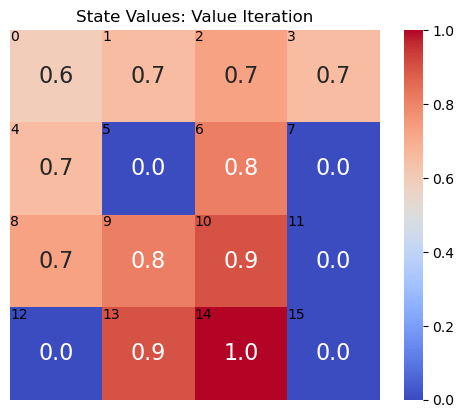

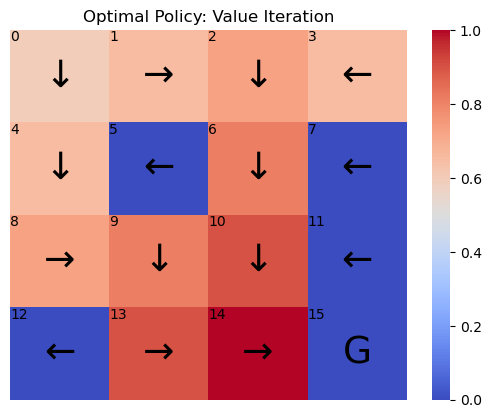

In [39]:

# Estimation
agent_valueItr = ValueIteration(env, DISCOUNT_FACTOR)
start_valueItr = time.time()
agent_valueItr.value_estimation()
end_valueItr = time.time()

# Ploting
plot_state_values(agent_valueItr.get_state_values().reshape(4, 4))
plt.title("State Values: Value Iteration")
plt.figure()
plot_optimal_policy(agent_valueItr)
plt.title("Optimal Policy: Value Iteration")

# Agent behavior based on the optimal policy
current_state = 0
done = False
while done == False:
    action = agent_valueItr.get_optimal_policy(current_state)
    next_state, reward, done = agent_valueItr.take_action(action)
    current_state = next_state


#### <a id='toc2_6_2_'></a>Policy Iteration: [](#toc0_)

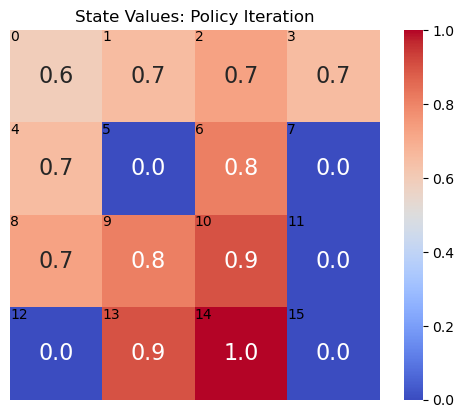

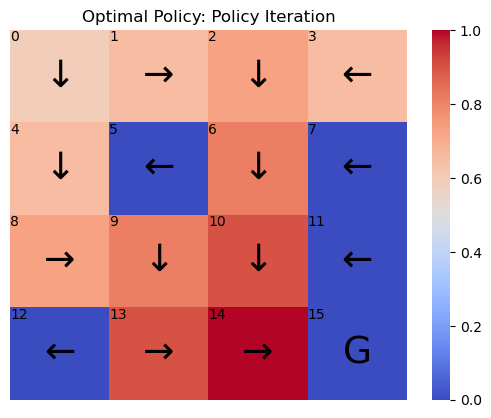

In [40]:
# Estimation
agent_policyItr = PolicyIteration(env, DISCOUNT_FACTOR)
start_policyItr = time.time()
agent_policyItr.policy_estimation()
end_policyItr = time.time()

# Ploting
plot_state_values(agent_policyItr.get_state_values().reshape(4, 4))
plt.title("State Values: Policy Iteration")
plt.figure()
plot_optimal_policy(agent_policyItr)
plt.title("Optimal Policy: Policy Iteration")

# Agent behavior based on the optimal policy
current_state = 0
done = False
while done == False:
    action = agent_policyItr.get_optimal_policy(current_state)
    next_state, reward, done = agent_policyItr.take_action(action)
    current_state = next_state

### <a id='toc2_7_'></a>Value Iteration VS. Policy Iteration [](#toc0_)

As you can see, both algorithms yield the same state values and optimal policy. Therefore, it is reasonable to compare their execution times to determine which one is faster. Since there is no difference in the results obtained from both algorithms.

#### <a id='toc2_7_1_'></a>Value Iteration: [](#toc0_)

In [42]:
valueItr_time = end_valueItr - start_valueItr
print("Value iteration time: "f"{valueItr_time:.3f}" " seconds")

Value iteration time: 0.079 secods


#### <a id='toc2_7_2_'></a>Policy Iteration: [](#toc0_)

In [43]:
policyItr_time = end_policyItr - start_policyItr
print("Policy iteration time: "f"{policyItr_time:.3f}" " seconds")

Policy iteration time: 0.041 secods


It appears that in our example, policy iteration is more than two times faster than value iteration. In fact, policy iteration is often faster because it avoids to evaluating all possible actions in each state. Instead, it focuses on the actions prescribed by the policy(not yet optimal), reducing the time complexity from $O(S ^ {2} A)$ to $O(S ^{2})$ (where $S$ is the number of states and $A$ is the number of possible actions).

The key behind this efficiency is that policy iteration suggests that if a particular action is chosen, it is beneficial to repeat that action multiple times until the state values change significantly. It is unnecessary to update the policy immediately after each action is taken. This approach allows for faster convergence and reduces the computational burden associated with evaluating every possible action at each state.

## <a id='toc3_'></a>Part 2: Q-Learning Algorithm [](#toc0_)

### <a id='toc3_1_'></a>Problem Description [](#toc0_)
There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

Let's get more familiar with this environment:

In [44]:
# hyperparameters
REPS = 20
EPISODES = 2000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 111
MAX_REWARD = 10

The initial state is:

In [45]:
# environment
env = gym.make('Taxi-v3', render_mode="human")
Initial_State, _ = env.reset(seed = STUDENT_NUM)
Initial_State

73

and the locations of taxi and passenger are as follows:

In [46]:
taxi_row, taxi_col, pass_idx, dest_idx = env.decode(Initial_State)
taxi_row, taxi_col, pass_idx, dest_idx

(0, 3, 3, 1)

Total number of states is:

In [48]:
env.observation_space.n

500

Total number of actions is:

In [49]:
env.action_space.n

6

### <a id='toc3_2_'></a>Q-Learning Algorithm [](#toc0_)
Q-learning is a reinforcement learning algorithm that enables an agent to learn an optimal policy in a Markov Decision Process (MDP) without prior knowledge of the environment's dynamics. The algorithm uses a value function called the Q-value to estimate the expected cumulative reward of taking an action in a given state. Through iterative updates using the Bellman equation, Q-learning gradually improves the Q-values based on the agent's interactions with the environment. By exploring and exploiting actions based on the current Q-values, the agent learns to make optimal decisions and maximize its long-term rewards.
$$
Q(S,A) = (1- \alpha)Q(S, A) + \alpha [R + \gamma max_{a}Q'(S', a)]
$$


### <a id='toc3_3_'></a>Implementation of Q-Learning Algorithm [](#toc0_)

In [50]:
class QLearningAgent():
    def __init__(self, env, epsilon, learning_rate, discount_factor, seed):
      self.env = env
      self.epsilon = epsilon
      self.learning_rate = learning_rate
      self.olr = learning_rate
      self.oeps = epsilon
      self.discount_factor = discount_factor
      self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
      self.seed = seed

    def choose_action(self, state):
      # With probability epsilon, choose a random action
      if np.random.rand() < self.epsilon:
        action = np.random.randint(low=0, high=self.env.action_space.n)
      # Otherwise, choose the action with the highest Q-value
      else:
        action = np.argmax(self.q_table[state])

      return action

    def update_q_table(self, state, action, next_state, reward):
      # Calculate the new Q-value using the Q-learning formula
      sample =  reward + self.discount_factor * (np.max([self.q_table[next_state, :]]))
      self.q_table[state][action] = (1 - self.learning_rate) * self.q_table[state][action] + self.learning_rate * sample
    
    def decay_epsilon(self):
      decay_rate = 0.5
      self.epsilon = self.epsilon * decay_rate

    def decrease_learning_rate_linearly(self):
      self.learning_rate = max(self.learning_rate - (self.olr / EPISODES), 0)

    def decrease_learning_rate_exponentially(self):
      decay_rate = 0.99
      self.learning_rate = self.learning_rate * decay_rate

    def take_action(self, action):
      next_state, reward, done, _, _= self.env.step(action)
      return next_state, reward, done

    def get_optimal_policy(self, state):
      return np.argmax(self.q_table[state])

    def get_q_values(self):
      return self.q_table

    def reset(self):
      self.learning_rate = self.olr
      self.epsilon = self.oeps
      return self.env.reset(seed=self.seed)

### <a id='toc3_4_'></a>Constant Learning Rate VS. Decaying Learning Rate [](#toc0_)

- Constant Learning Rate:
    - In this approach, the learning rate remains constant throughout the entire training duration and does not change.


- Decaying Learning Rate:
    - In this approach, the learning rate decreases over time. Typically, a decaying function such as a linear or exponential function is used to determine the learning rate.

`run_episode` run the Q-learning algorithm for one episode, an episode is considered completed when the agent reaches the goal state. 

In [51]:
def run_episode(agent:QLearningAgent):
    total_reward = 0
    state, _ = agent.reset()
    done = False
    while done == False:
      best_action = agent.choose_action(state)
      next_state, reward, done = agent.take_action(best_action)
      agent.update_q_table(state, best_action, next_state, reward)
      state = next_state
      total_reward += reward
    agent.decay_epsilon()
    return total_reward

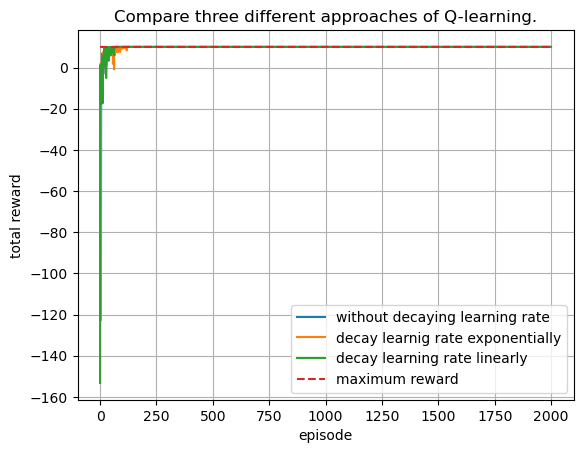

In [52]:

env = gym.make('Taxi-v3')

total_reward = np.zeros(EPISODES)
agent = QLearningAgent(env, EPSILON, LEARNING_RATE, DISCOUNT, STUDENT_NUM)
for rep in range(REPS):
  for episode in range(EPISODES):
    reward = run_episode(agent)
    total_reward[episode] += reward
total_reward /= REPS

total_reward_decay_lr_linear = np.zeros(EPISODES)
agent = QLearningAgent(env, EPSILON, LEARNING_RATE, DISCOUNT, STUDENT_NUM)
for rep in range(REPS):
  for episode in range(EPISODES):
    reward = run_episode(agent)
    total_reward_decay_lr_linear[episode] += reward
    agent.decrease_learning_rate_linearly()
total_reward_decay_lr_linear /= REPS

total_reward_decay_lr_exp = np.zeros(EPISODES)
agent = QLearningAgent(env, EPSILON, LEARNING_RATE, DISCOUNT, STUDENT_NUM)
for rep in range(REPS):
  for episode in range(EPISODES):
    reward = run_episode(agent)
    total_reward_decay_lr_exp[episode] += reward
    agent.decrease_learning_rate_exponentially()

total_reward_decay_lr_exp /= REPS

x = np.arange(0, EPISODES)
plt.plot(x, total_reward, label="without decaying learning rate")
plt.plot(x, total_reward_decay_lr_exp, label ="decay learnig rate exponentially")
plt.plot(x, total_reward_decay_lr_linear, label="decay learning rate linearly")
plt.plot(x, np.ones(x.shape[0]) * MAX_REWARD, '--', label="maximum reward")
plt.xlabel("episode")
plt.ylabel("total reward")
plt.title("Compare three different approaches of Q-learning.")
plt.legend()
plt.grid()

As you can see in the figure above, there is not a significant difference in convergence time among different methods. I believe the reason for this is that once we reach the optimal values in this case, there is no significant difference in whether we update them or not because the system has already converged. However, upon further research, I came across something that contradicts this notion.

Decaying the learning rate can often be beneficial in the training process of many machine learning algorithms, including reinforcement learning. Here are a few reasons why decaying the learning rate is commonly done:

1. Convergence: Initially, a higher learning rate allows for larger updates and faster exploration of the parameter space.

2. Stability: A high learning rate can cause the training process to become unstable, leading to large oscillations or divergence. By decaying the learning rate, the updates become smaller over time, which can help stabilize the training and prevent overshooting or oscillations around the optimal solution.

3. Exploration-Exploitation Trade-off: In reinforcement learning, decaying the learning rate can be useful for balancing exploration and exploitation. Initially, a higher learning rate encourages more exploration, allowing the agent to discover different actions and learn about the environment. As training progresses, reducing the learning rate enables the agent to exploit the learned knowledge and refine its policy based on the observed rewards.


The above result is more general, and it is not appropriate to make a definitive decision based solely on one example.

 Another important point observed during testing different methods for decaying the learning rate is that we should be cautious about decaying the learning rate too early, before the convergence of values, as it can prevent the agent from learning the optimal policy.


### <a id='toc3_5_'></a>Visualizing the Agent's Behavior [](#toc0_)

The behavior of the `agent` can be observed in a graphical environment provided by the Gym library.

In [53]:
env = gym.make('Taxi-v3', render_mode="human")
state,_ = env.reset(seed=STUDENT_NUM)
env.render()
q_values = agent.get_q_values()
done = False
while done == False:
    action = agent.get_optimal_policy(state)
    next_state, reward, done, _, _= env.step(action)
    state = next_state
    print(reward)

env.close()

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
20


The reward for each step is displayed above, with a total sum of $10$. There is a negative reward of $-1$ for each movement and a positive reward of $+20$ for successfully driving the passenger to her destination.